## Proximity Learning with CatBoost

This Python code trains a **CatBoost regression model** and computes **instance similarity** based on **proximity learning**. The similarity between two instances is determined by how frequently they appear in the same **leaf node** across trees, with an additional weight based on **tree importance**.

---

## Similarity Computation

We use **Equation (2)** and **Equation (3)** to compute instance similarity.

### Equation (2): Instance Similarity Score

$$
P(i,j) = \frac{1}{N} \sum_{t=1}^{N} \Delta_t \cdot I_t(v(j) = v(i))
$$

where:
- \( N \) is the **total number of trees**.
- \( I_t(v(j) = v(i)) \) is **1 if two instances share a leaf** in tree \( t \), otherwise **0**.
- \( \Delta_t \) is the **importance of tree** \( t \), computed as:

### Equation (3): Tree Importance

$$
\Delta_t = \frac{E(t) - E(t-1)}{\sum_{t=1}^{N} (E(t) - E(t-1))}
$$

where:
- \( E(t) \) is the **error of the model** after tree \( t \).
- The difference \( E(t) - E(t-1) \) measures the **impact of tree \( t \) in reducing error**.

---

## Intuition

- **Instance similarity** is based on **how often instances appear in the same leaf** across trees.
- Trees with **higher importance** (greater error reduction) **contribute more** to the similarity score.
- This approach captures **local relationships** rather than relying on global distance metrics.

This method enhances **interpretability** and **clustering** in machine learning models by leveraging the structure of **gradient boosting decision trees** (GBDTs) like CatBoost.

---

## Step 1: Import Necessary Libraries

In [39]:
import numpy as np
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import mean_squared_error, roc_auc_score
from scipy.spatial.distance import pdist, squareform
import numpy as np
import scipy.stats as stats

## Step 2: Loading and Processing Data

In [41]:
# List of datasets to use
datasets = ["11_donors",  "22_magic.gamma", "24_mnist",  "27_PageBlocks", "2_annthyroid", "30_satellite", "32_shuttle", "33_skin",  
            "6_cardio", "7_Cardiotocography"]

def load_dataset(dataset):
    path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
    data = np.load(path, allow_pickle=True)
    return data['X'], data['y']


In [42]:
X,y=load_dataset(datasets[6])
y

array([1, 0, 0, ..., 0, 1, 0])

## Step 3: Defining Function to Train CatBoost and Compute Similarity

In [141]:
def compute_similarity(X, y, active_learning_fraction=0.6, query_strategy='clusters'):
    # Ensure stratified split to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    n_labeled = int(active_learning_fraction * len(X_train))
    
    # Ensure label diversity
    unique_labels = np.unique(y_train)
    if len(unique_labels) == 1:
        raise ValueError("Training set has only one unique target value. Adjust sampling method.")
    
    # Active Learning: Query Strategy - Clusters
    kmeans = KMeans(n_clusters=n_labeled, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Select representative points for labeling
    selected_indices = []
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices.append(cluster_indices[0])  # Pick first point in each cluster
    
    X_labeled, y_labeled = X_train[selected_indices], y_train[selected_indices]
    X_unlabeled, y_unlabeled = np.delete(X_train, selected_indices, axis=0), np.delete(y_train, selected_indices, axis=0)
    
    # Train CatBoost Regressor on labeled data
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_labeled, y_labeled)
    
    # Predict labels for the unlabeled dataset using the trained model
    y_unlabeled_pred = model.predict(X_unlabeled)
    
    X_labeled = np.vstack((X_labeled, X_unlabeled))
    y_labeled = np.hstack((y_labeled, y_unlabeled_pred))
    
    # Evaluate model performance using AUC, ensuring multiple classes exist
    if len(np.unique(y_unlabeled_pred)) > 1:
        auc_score = roc_auc_score(y_unlabeled, y_unlabeled_pred)
        print(f"Model AUC Score: {auc_score:.4f}")
    else:
        print("Skipping AUC calculation: y_test contains only one class.")
    
    # Get leaf indices for each instance
    leaf_indices_train = model.calc_leaf_indexes(X_labeled)
    
    # Compute errors for tree importance
    preds = model.predict(X_labeled)
    errors = np.square(preds - y_labeled)
    
    tree_errors = [
        mean_squared_error(y_labeled, np.array(list(model.staged_predict(X_labeled, ntree_end=i))[-1]))
        for i in range(1, model.tree_count_ + 1)
    ]
    
    tree_errors = np.array(tree_errors)
    
    # Compute tree importance
    delta_t = np.diff(tree_errors, prepend=0)
    delta_t = np.abs(delta_t)
    delta_t /= np.sum(delta_t)
    
    # Compute similarity scores
    num_trees = model.tree_count_
    similarity_matrix = np.zeros((len(X_labeled), len(X_labeled)))
    
    for t in range(num_trees):
        leaf_assignments = leaf_indices_train[:, t]
        for i in range(len(X_labeled)):
            for j in range(len(X_labeled)):
                if leaf_assignments[i] == leaf_assignments[j]:
                    similarity_matrix[i, j] += delta_t[t]
    
    similarity_matrix /= num_trees
    
    # Ensure all values are positive using Min-Max scaling
    scaler = MinMaxScaler()
    similarity_matrix = scaler.fit_transform(similarity_matrix)

    inlier_indices_all = np.where(y_labeled == 0)[0]  # All available inliers
    outlier_indices_all = np.where(y_labeled == 1)[0]  # All available outliers
    inlier_indices = np.random.choice(inlier_indices_all, 20, replace=False)
    outlier_indices = np.random.choice(outlier_indices_all, 10, replace=False)
    selected_indices = np.concatenate([inlier_indices, outlier_indices])
    similarity_matrix = similarity_matrix[selected_indices][:, selected_indices]
    #similarity_matrix[20:30, 20:30] *= -1

    return similarity_matrix, model

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_auc_score
from scipy.spatial.distance import cdist
from catboost import CatBoostRegressor
import numpy as np
from sklearn.cluster import KMeans

def compute_similarity(X, y, active_learning_fraction=0.6, query_strategy='clusters'):
    # Stratified split for class balance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    n_labeled = int(active_learning_fraction * len(X_train))
    
    # Ensure label diversity
    unique_labels = np.unique(y_train)
    if len(unique_labels) == 1:
        raise ValueError("Training set has only one unique target value. Adjust sampling method.")
    
    # Active Learning: Clustering strategy
    kmeans = KMeans(n_clusters=n_labeled, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Select representative points
    selected_indices = []
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices.append(cluster_indices[0])  # Pick first point in each cluster
    
    X_labeled, y_labeled = X_train[selected_indices], y_train[selected_indices]
    X_unlabeled, y_unlabeled = np.delete(X_train, selected_indices, axis=0), np.delete(y_train, selected_indices, axis=0)
    
    # Train CatBoost model
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_labeled, y_labeled)
    
    # Predict labels for the unlabeled dataset
    y_unlabeled_pred = model.predict(X_unlabeled)
    
    # Expand labeled dataset
    X_labeled = np.vstack((X_labeled, X_unlabeled))
    y_labeled = np.hstack((y_labeled, y_unlabeled_pred))
    
    # Evaluate model performance
    if len(np.unique(y_unlabeled_pred)) > 1:
        auc_score = roc_auc_score(y_unlabeled, y_unlabeled_pred)
        print(f"Model AUC Score: {auc_score:.4f}")
    else:
        print("Skipping AUC calculation: y_test contains only one class.")
    
    # Compute tree-based similarity
    leaf_indices_train = model.calc_leaf_indexes(X_labeled)
    preds = model.predict(X_labeled)
    errors = np.square(preds - y_labeled)

    tree_errors = [
        mean_squared_error(y_labeled, np.array(list(model.staged_predict(X_labeled, ntree_end=i))[-1]))
        for i in range(1, model.tree_count_ + 1)
    ]
    
    tree_errors = np.array(tree_errors)
    
    # Compute tree importance
    delta_t = np.diff(tree_errors, prepend=0)
    delta_t = np.abs(delta_t)
    delta_t /= np.sum(delta_t)
    
    # Compute similarity matrix
    num_trees = model.tree_count_
    similarity_matrix = np.zeros((len(X_labeled), len(X_labeled)))
    
    for t in range(num_trees):
        leaf_assignments = leaf_indices_train[:, t]
        for i in range(len(X_labeled)):
            for j in range(len(X_labeled)):
                if leaf_assignments[i] == leaf_assignments[j]:
                    similarity_matrix[i, j] += delta_t[t]
    
    similarity_matrix /= num_trees
    
    # Normalize similarity values
    scaler = MinMaxScaler()
    similarity_matrix = scaler.fit_transform(similarity_matrix)

    # Select random inliers and outliers
    np.random.seed(42)
    inlier_indices_all = np.where(y_labeled == 0)[0]  
    outlier_indices_all = np.where(y_labeled == 1)[0]  
    inlier_indices = np.random.choice(inlier_indices_all, 20, replace=False)
    outlier_indices = np.random.choice(outlier_indices_all, 10, replace=False)
    selected_indices = np.concatenate([inlier_indices, outlier_indices])

    # Extract the 30x30 similarity sub-matrix
    similarity_matrix = similarity_matrix[selected_indices][:, selected_indices]

    # Compute Euclidean distance matrix
    distance_matrix = cdist(X_labeled[selected_indices], X_labeled[selected_indices], metric='euclidean')

    # Normalize distance matrix to [0,1]
    scaler = MinMaxScaler()
    distance_matrix = scaler.fit_transform(distance_matrix)

    return similarity_matrix, distance_matrix, model


## Step 4: Training Model and Computing Similarity for Each Dataset

In [163]:
results = {}
for dataset in datasets:
    print(f'Processing {dataset}...')
    
    # Load dataset
    X, y = load_dataset(dataset)
    
    # Sub-sample up to 2000 instances
    sample_size = min(2000, len(X))
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample, y_sample = X[indices], y[indices]
    
    # Compute similarity and distance matrices
    similarity_matrix, distance_matrix, model = compute_similarity(X_sample, y_sample)
    
    # Store results
    results[dataset] = {
        'similarity_matrix': similarity_matrix,
        'distance_matrix': distance_matrix,
        'model': model
    }

print("Processing complete for all datasets!")


Processing 11_donors...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (607) found smaller than n_clusters (960). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Model AUC Score: 1.0000
Processing 22_magic.gamma...
Model AUC Score: 0.8417
Processing 24_mnist...
Model AUC Score: 0.9992
Processing 27_PageBlocks...
Model AUC Score: 0.9572
Processing 2_annthyroid...
Model AUC Score: 0.9975
Processing 30_satellite...
Model AUC Score: 0.9494
Processing 32_shuttle...
Model AUC Score: 1.0000
Processing 33_skin...
Model AUC Score: 1.0000
Processing 6_cardio...
Model AUC Score: 1.0000
Processing 7_Cardiotocography...
Model AUC Score: 0.9888
Processing complete for all datasets!


## Step 5: Plotting Similarity and distance Heatmaps

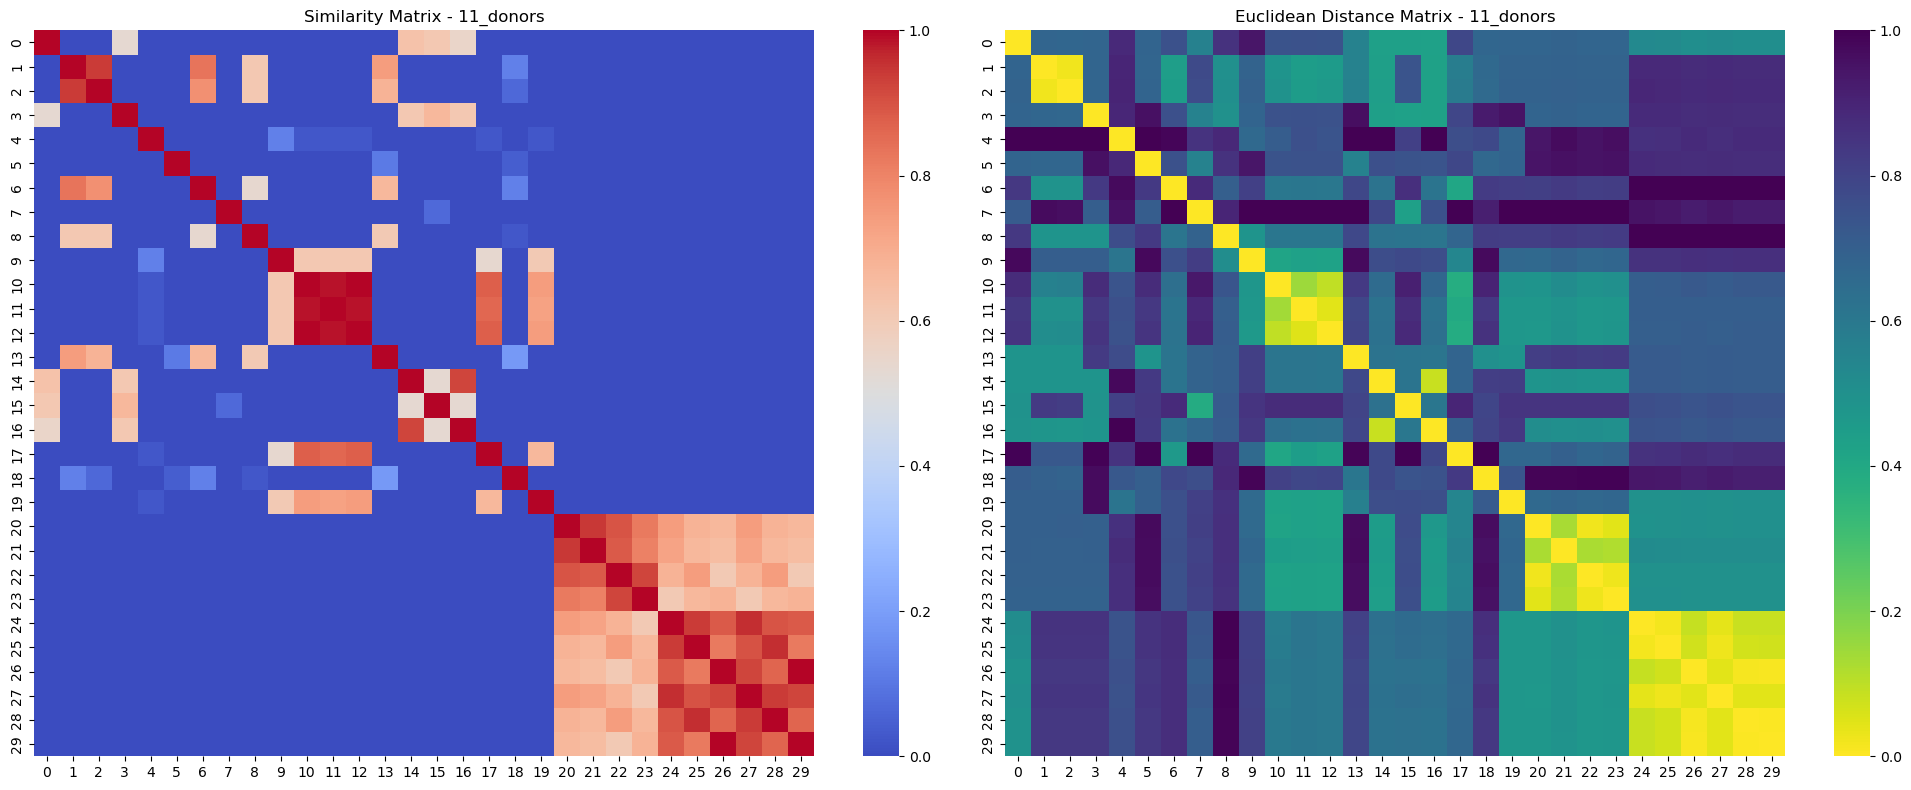

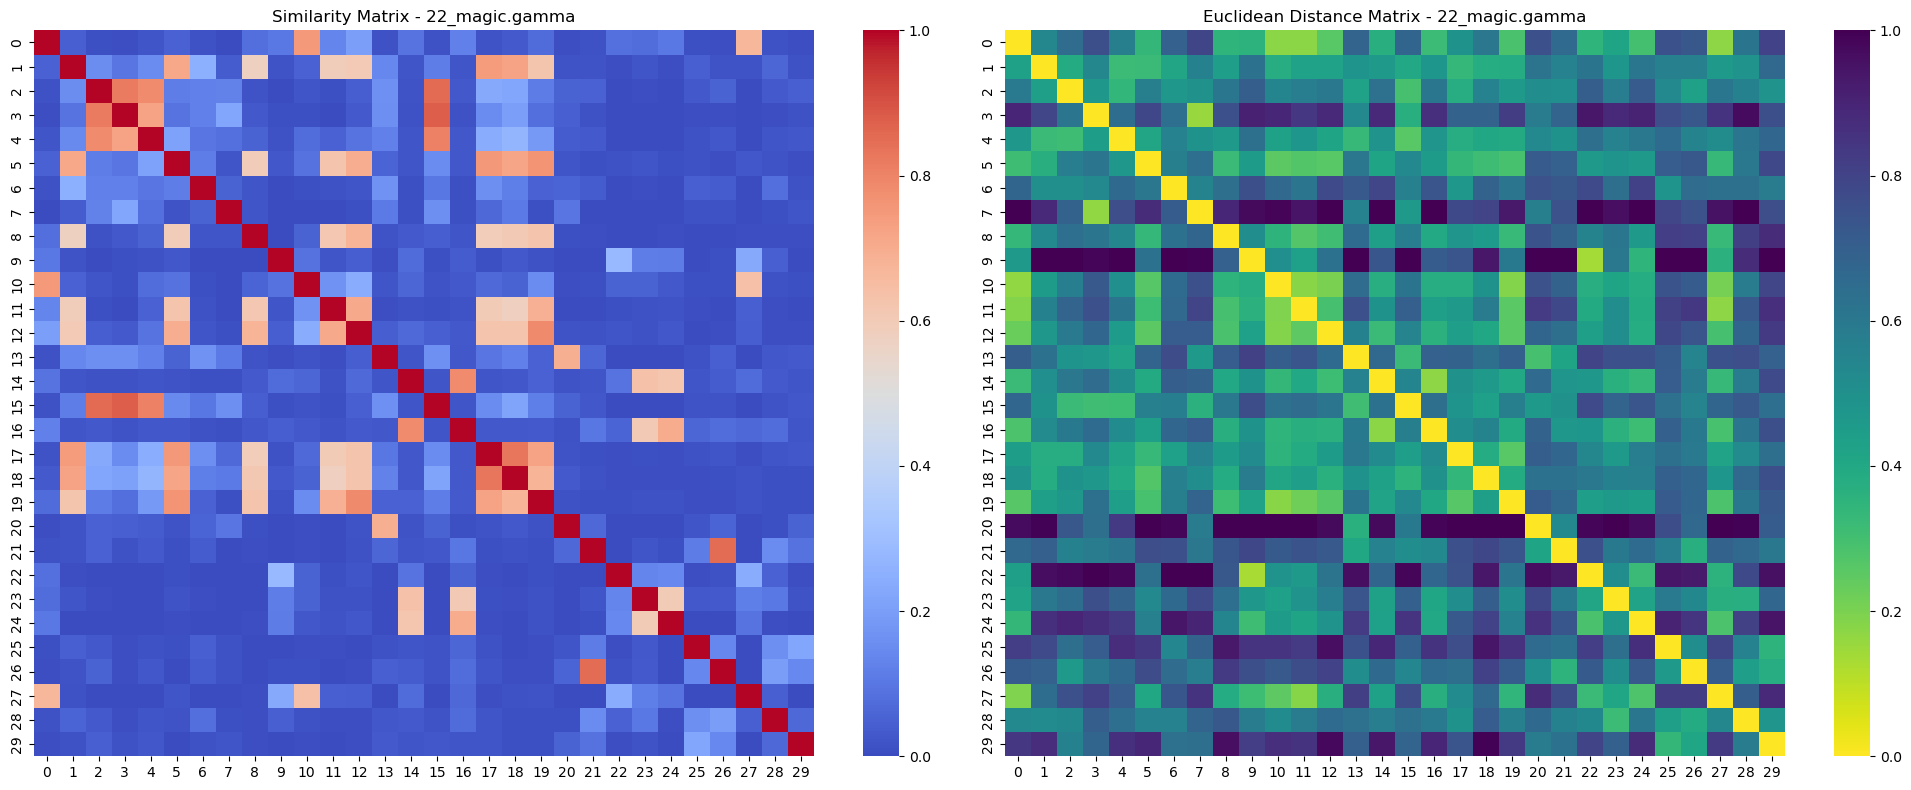

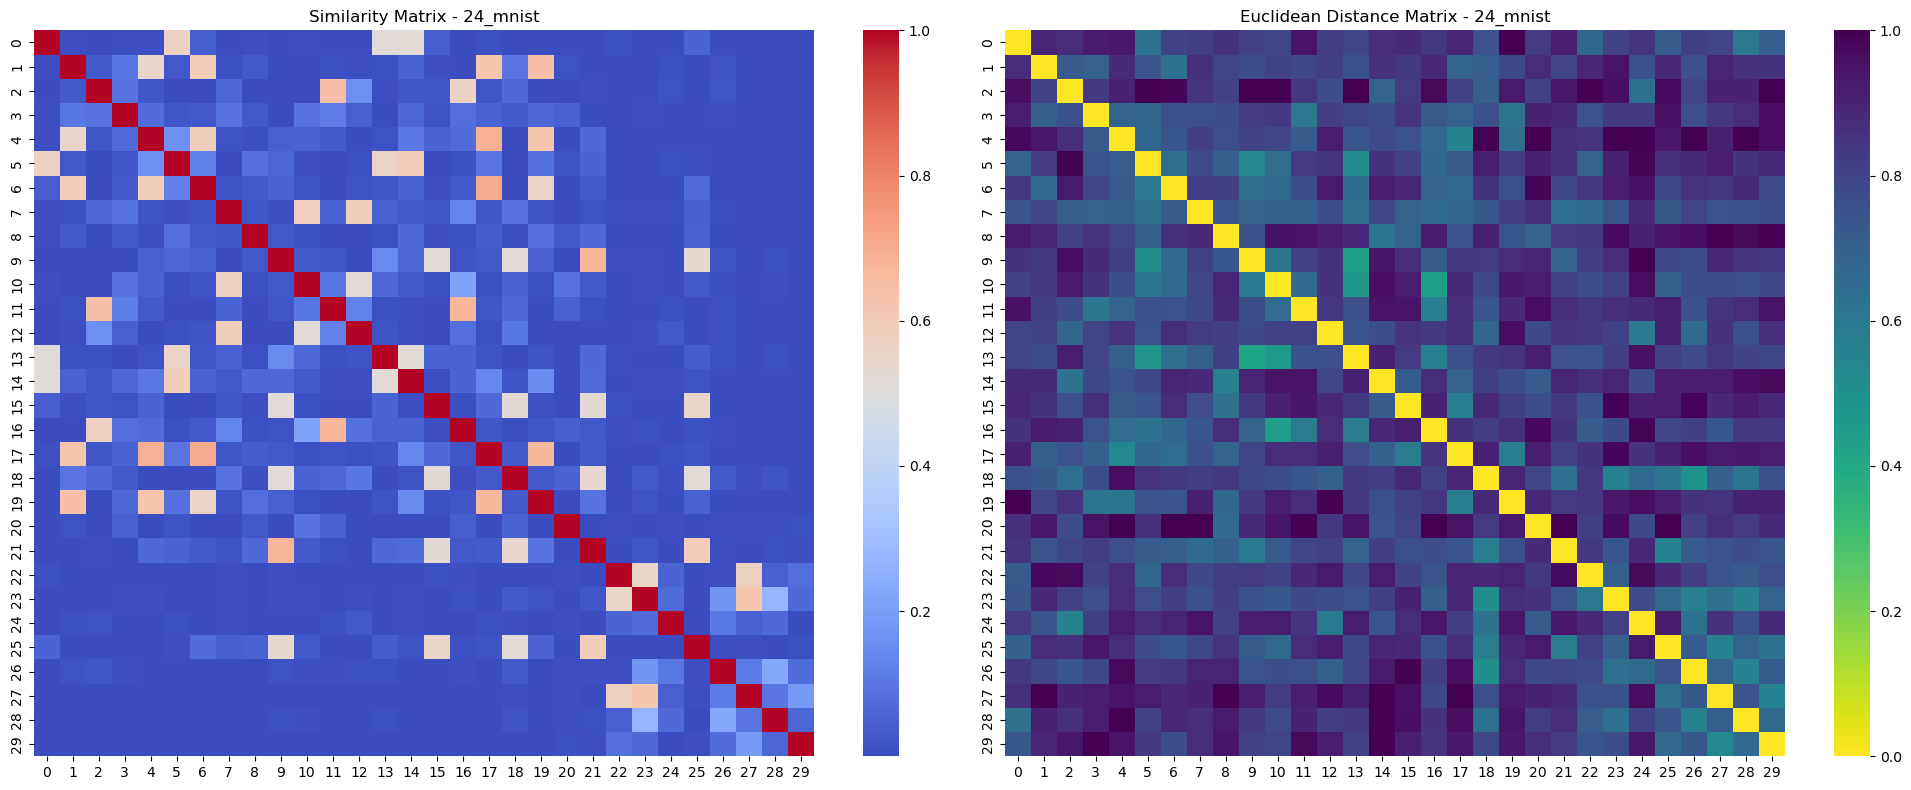

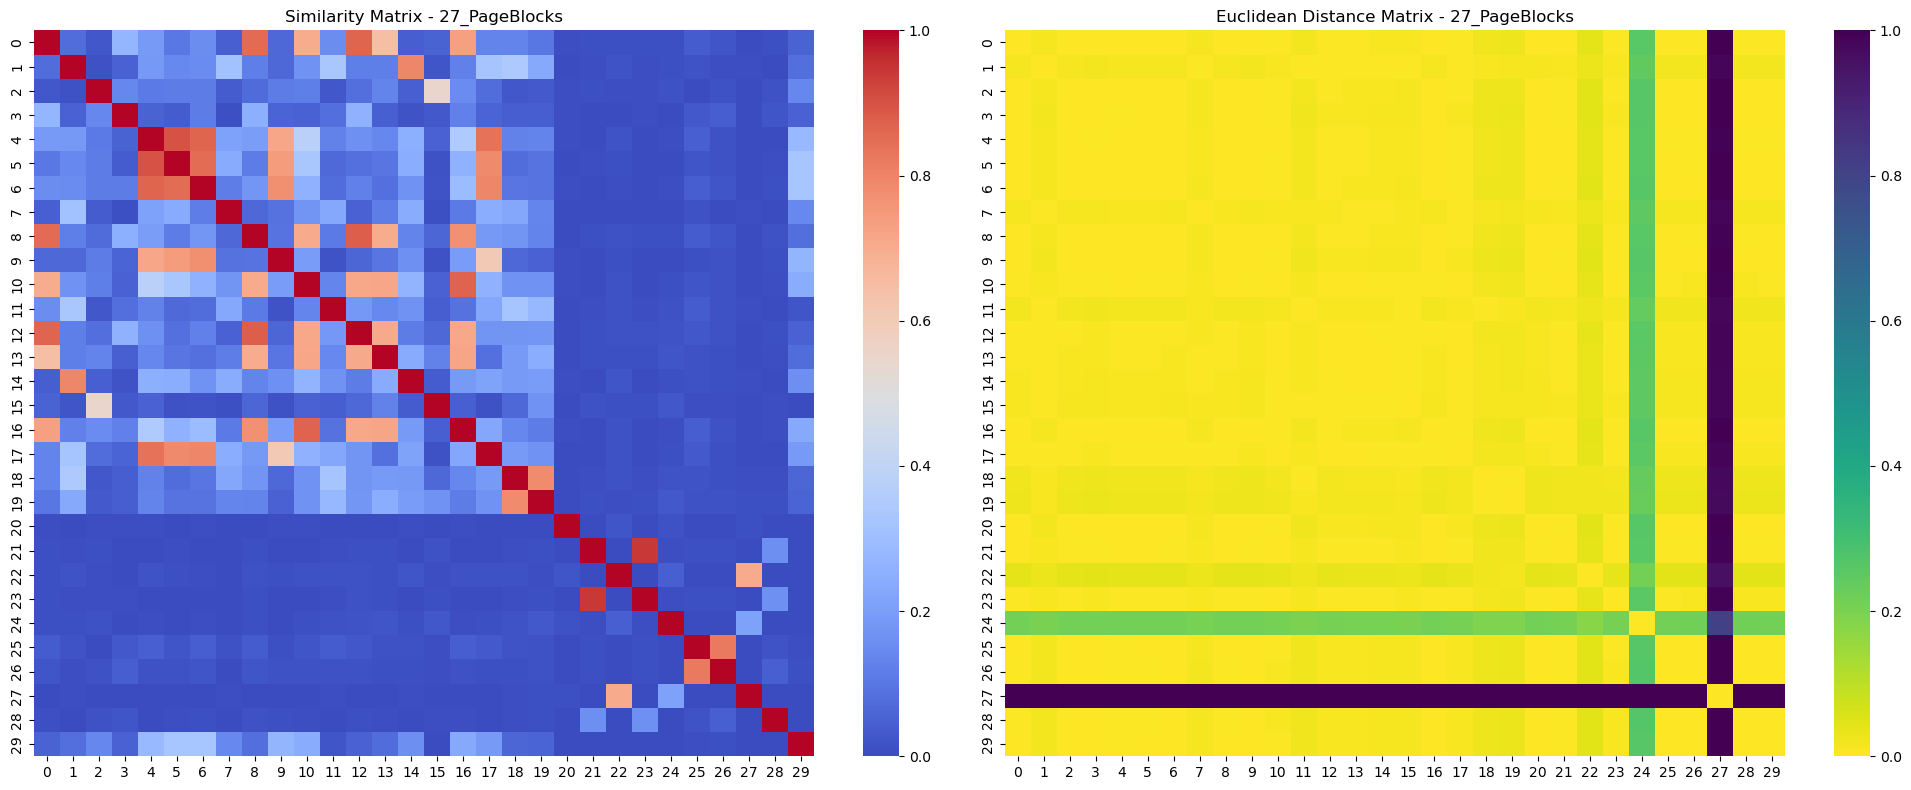

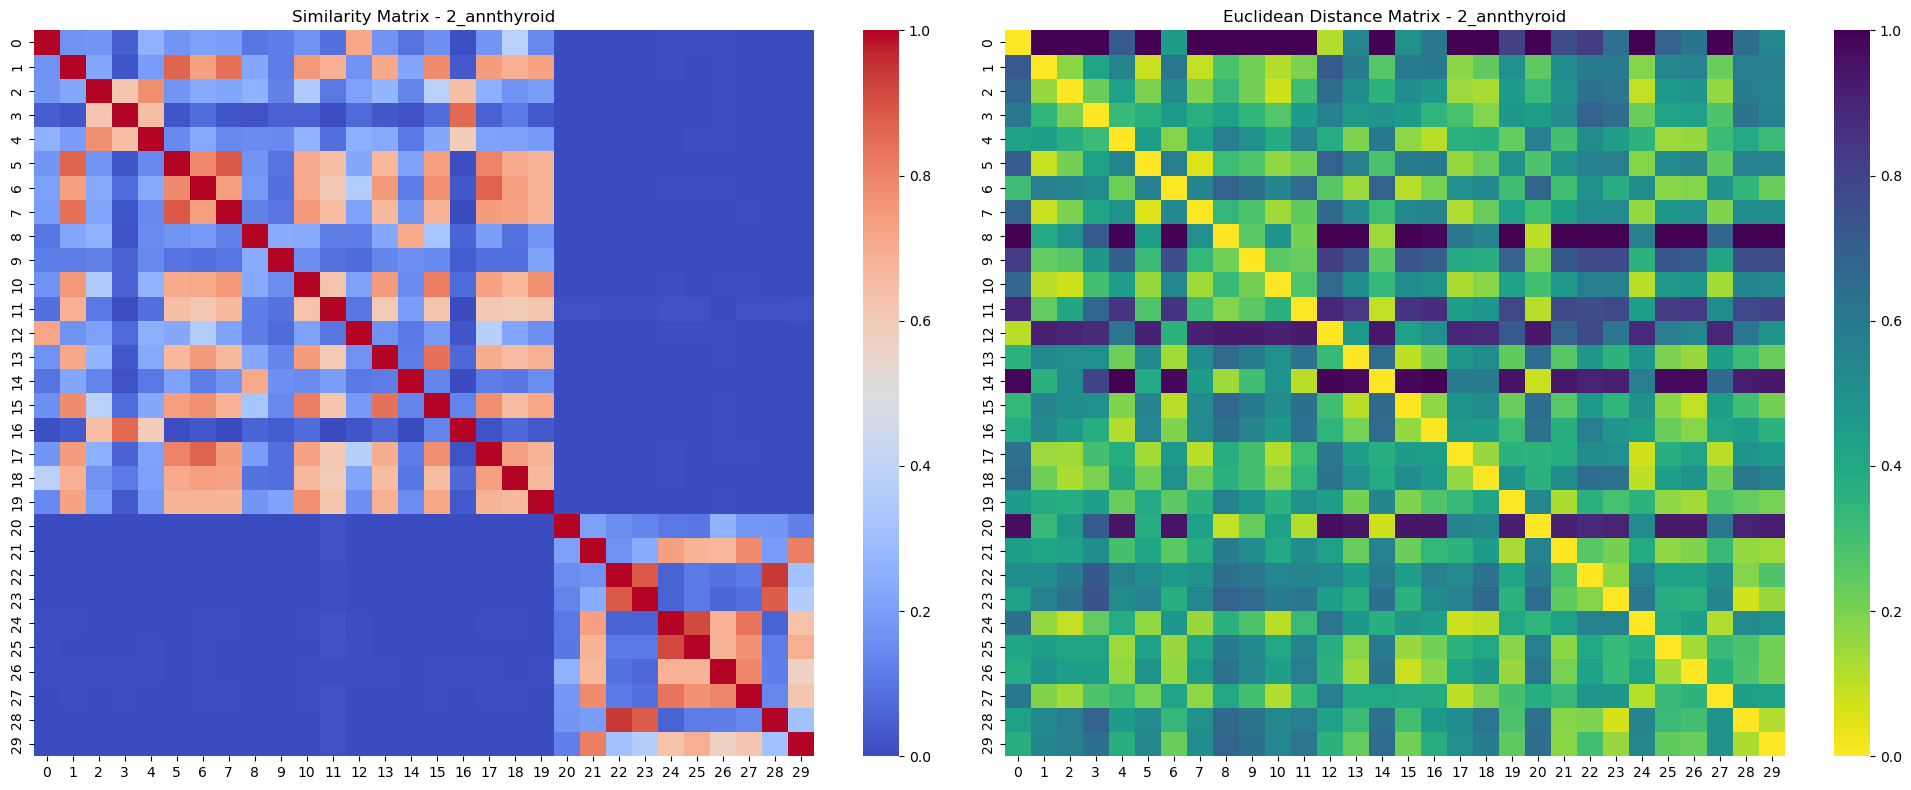

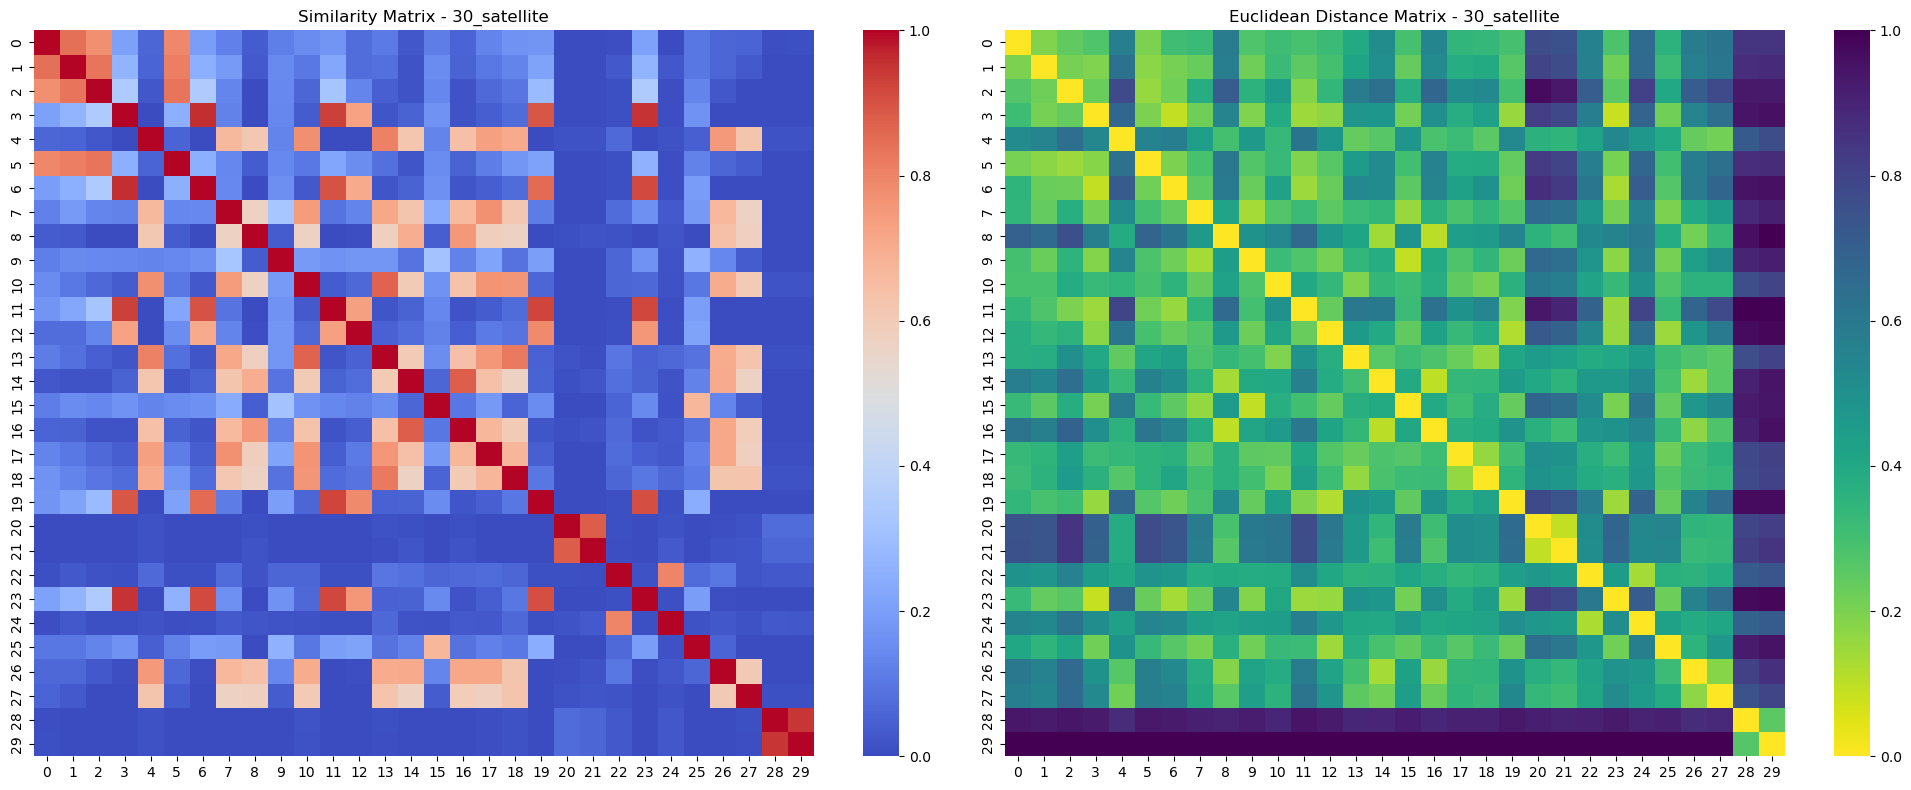

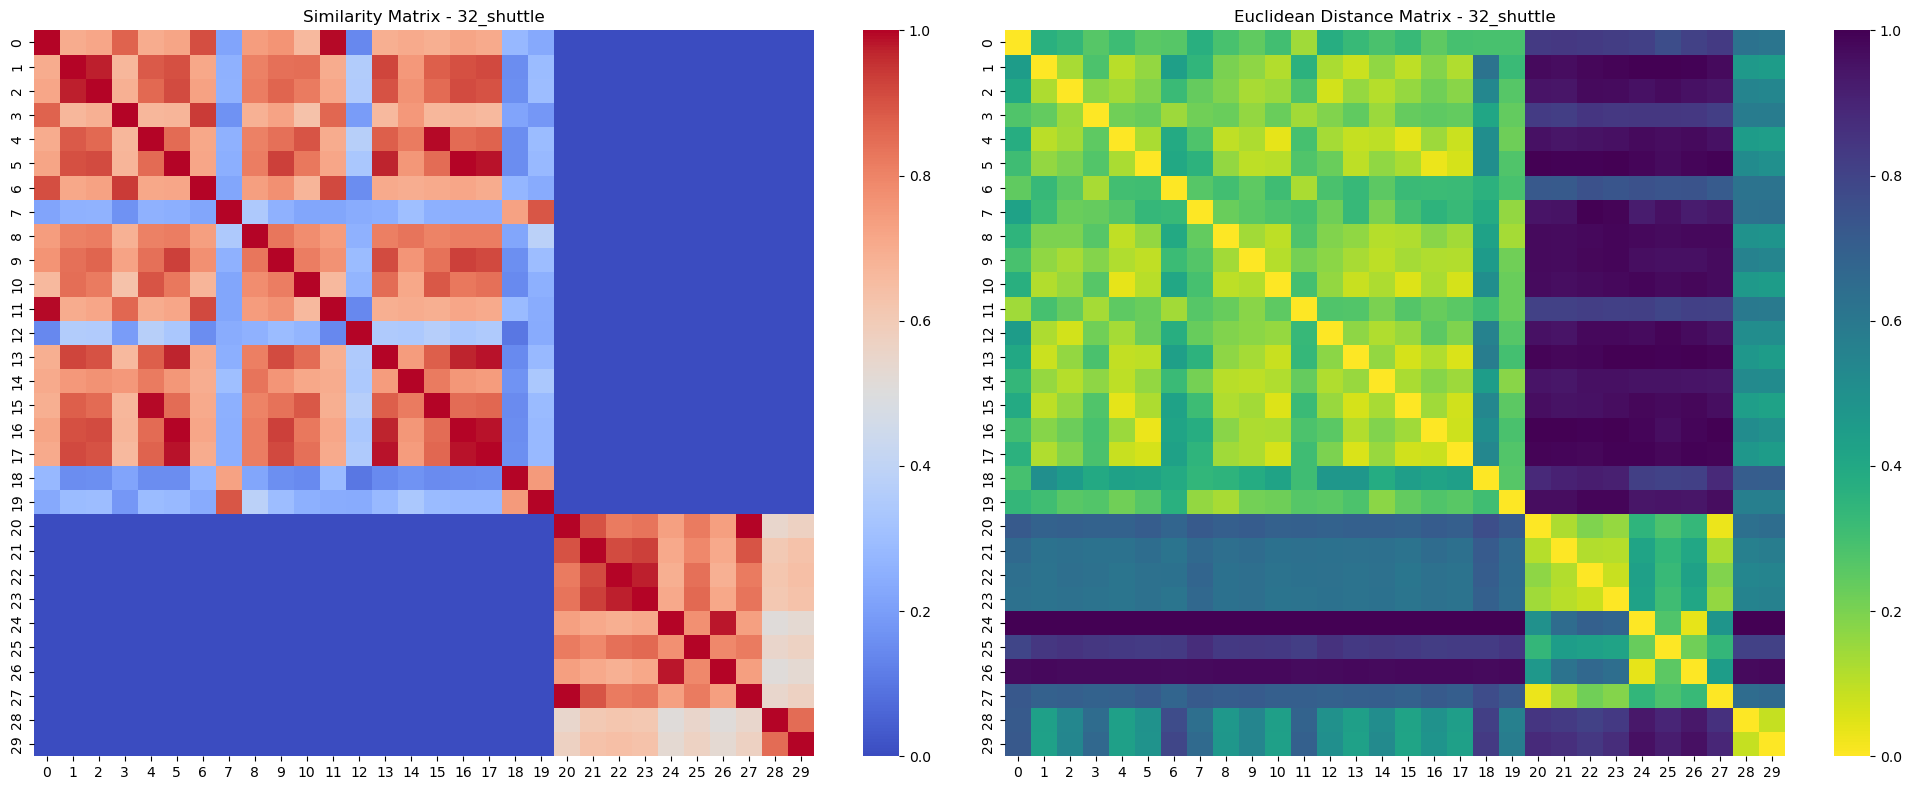

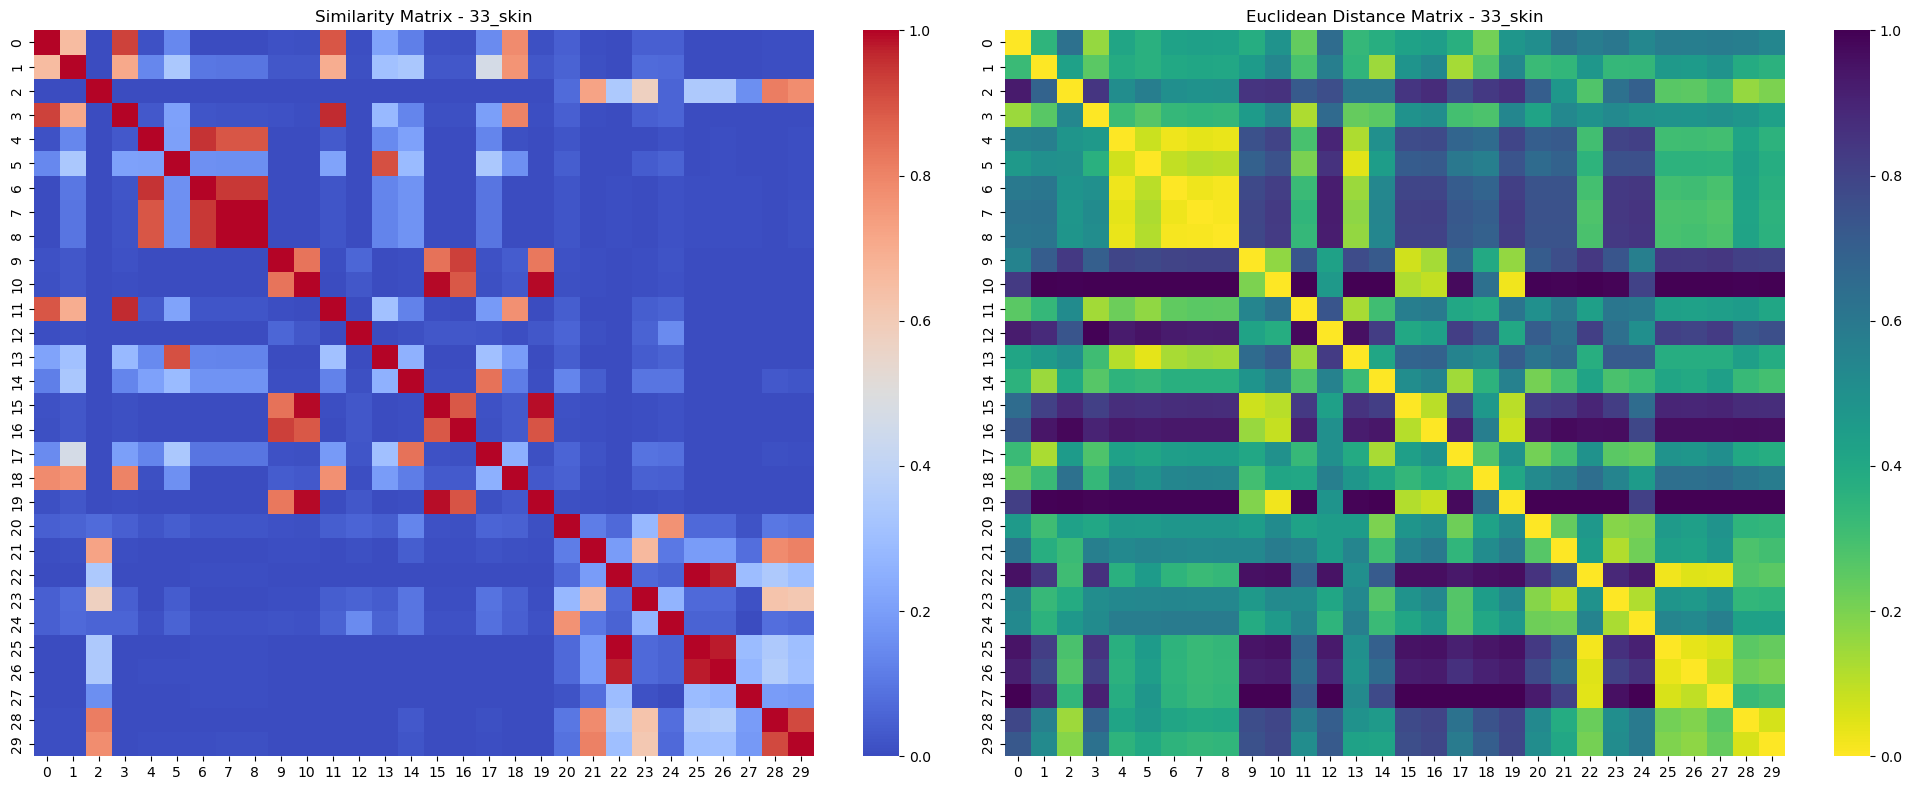

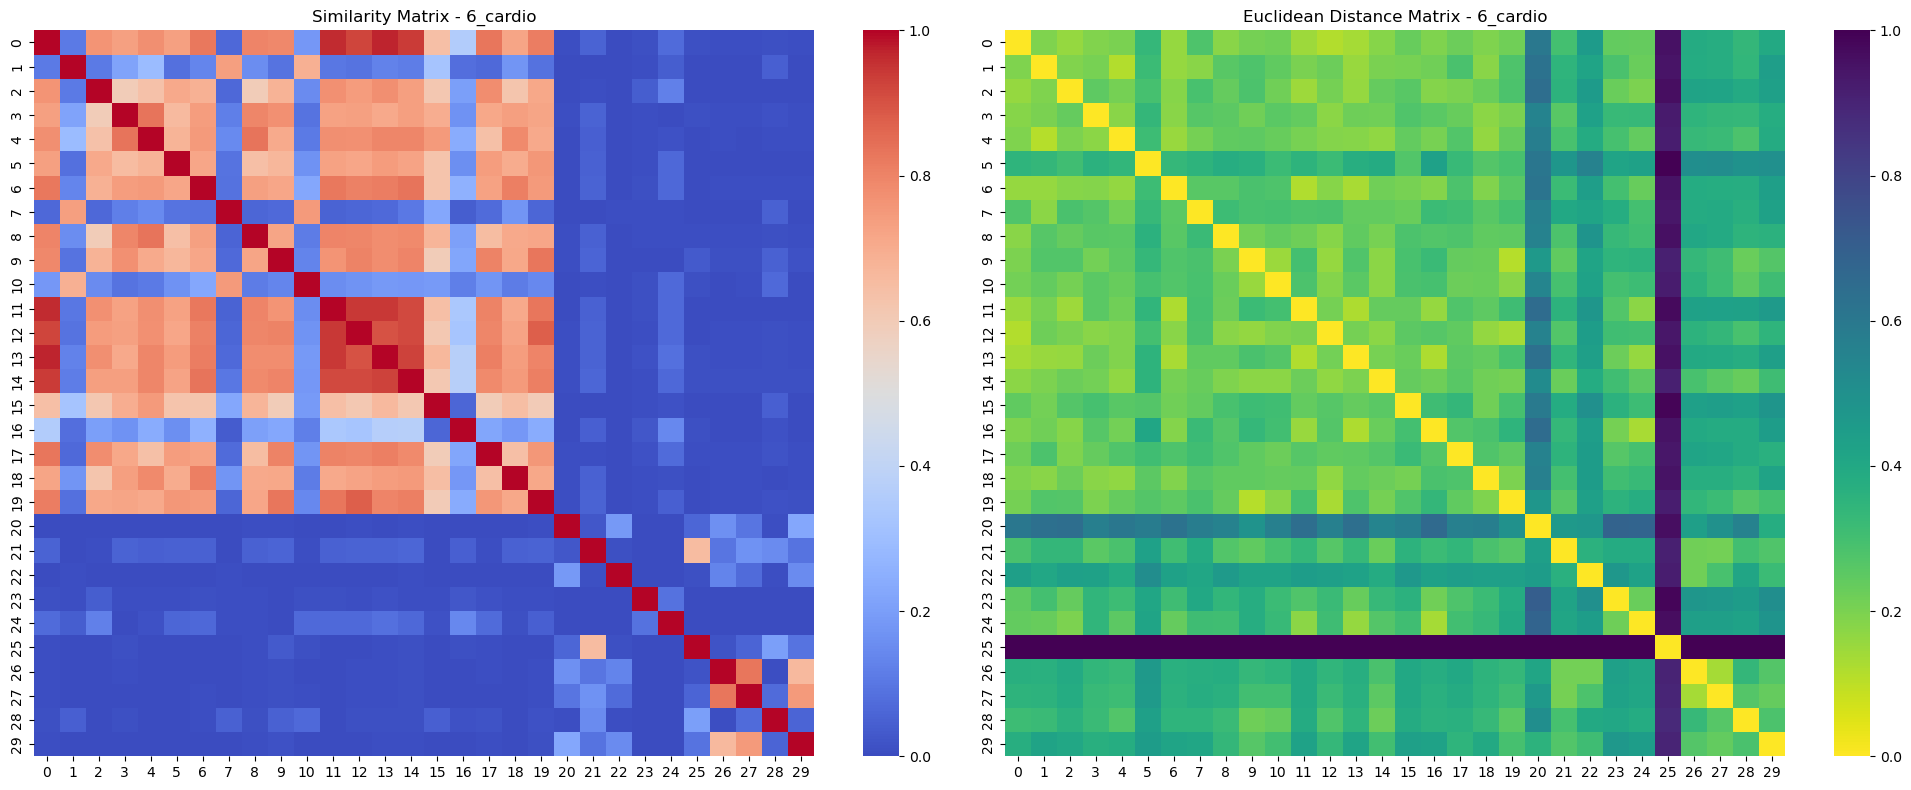

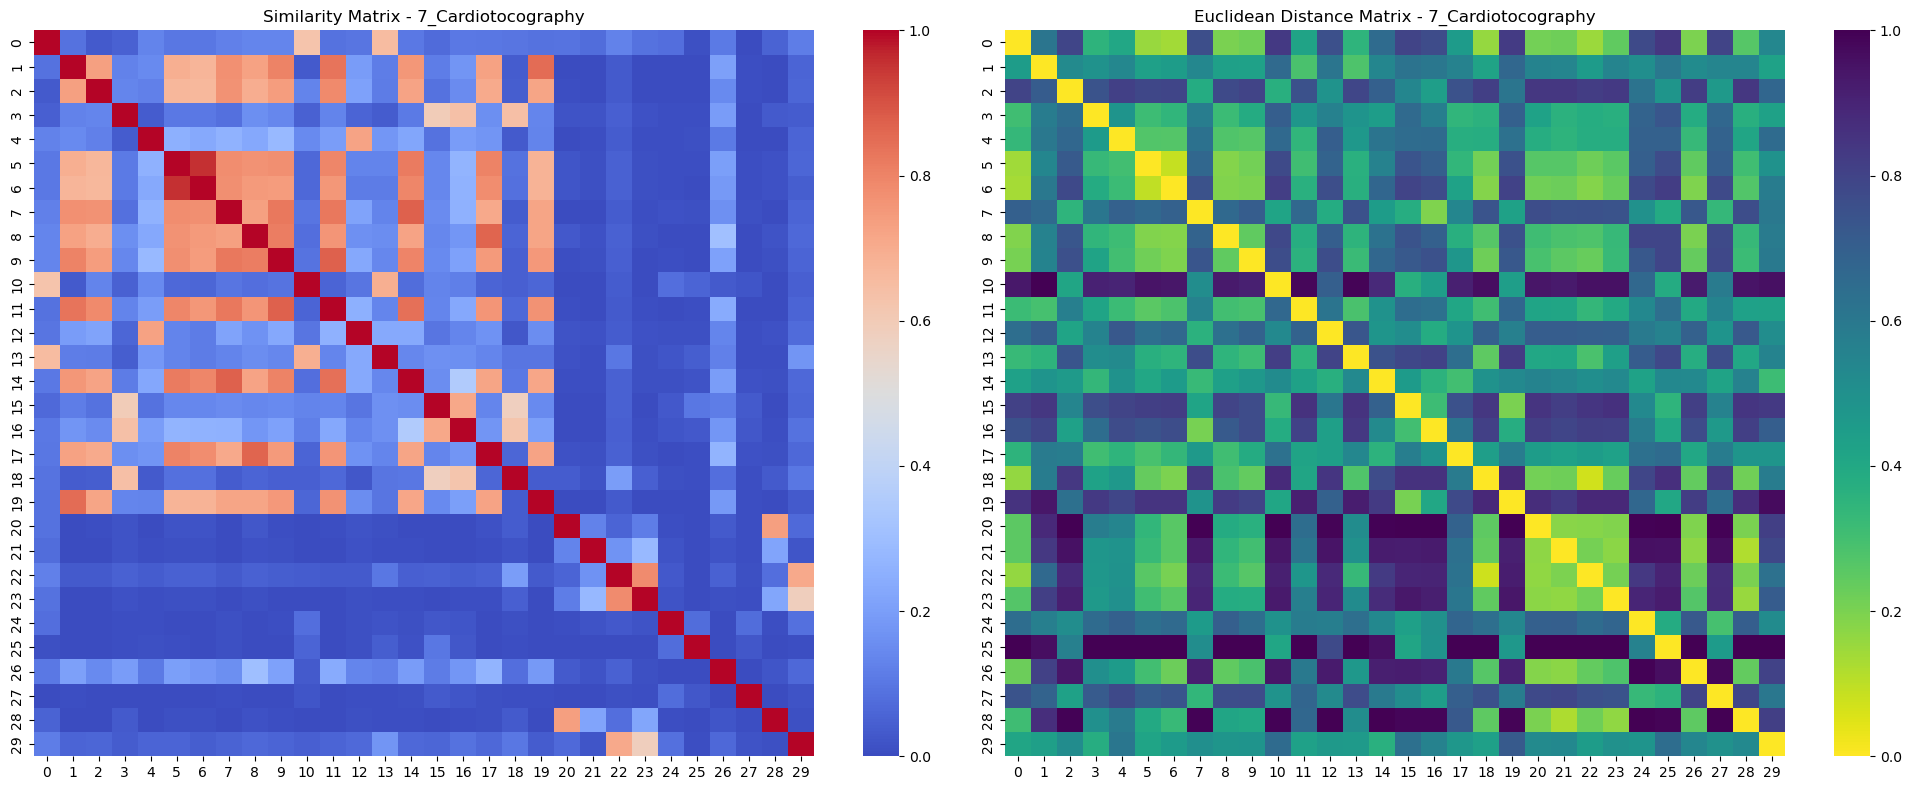

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_and_distance(similarity_matrix, distance_matrix, dataset_name):
  
    fig, axes = plt.subplots(1, 2, figsize=(20, 8)) 

    sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False, ax=axes[0])
    axes[0].set_title(f'Similarity Matrix - {dataset_name}')

    sns.heatmap(distance_matrix, cmap='viridis_r', annot=False, ax=axes[1])
    axes[1].set_title(f'Euclidean Distance Matrix - {dataset_name}')

    plt.tight_layout()
    pdf_filename = f"{dataset_name}_similarity_distance_matrices.pdf"
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')

    # Show the plots
    plt.show()

# Loop through datasets and generate plots
for dataset_name in datasets:
    plot_similarity_and_distance(results[dataset_name]['similarity_matrix'], 
                                 results[dataset_name]['distance_matrix'], 
                                 dataset_name)

In [168]:
import numpy as np
from scipy.stats import spearmanr, pearsonr
from tabulate import tabulate  # For structured table formatting

def compare_similarity_distance_by_group(similarity_matrix, distance_matrix, dataset_name):
    # Extract different regions
    inlier_similarity = similarity_matrix[:20, :20].flatten()  # Inliers only
    inlier_distance = distance_matrix[:20, :20].flatten()

    outlier_similarity = similarity_matrix[20:30, 20:30].flatten()  # Outliers only
    outlier_distance = distance_matrix[20:30, 20:30].flatten()

    cross_similarity = similarity_matrix[:20, 20:30].flatten()  # Inliers vs Outliers
    cross_distance = distance_matrix[:20, 20:30].flatten()

    # Compute correlation function
    def compute_correlations(similarity_values, distance_values):
        pearson_corr, _ = pearsonr(similarity_values, distance_values)
        spearman_corr, _ = spearmanr(similarity_values, distance_values)
        return pearson_corr, spearman_corr

    # Compute correlations for each case
    inlier_pearson, inlier_spearman = compute_correlations(inlier_similarity, inlier_distance)
    outlier_pearson, outlier_spearman = compute_correlations(outlier_similarity, outlier_distance)
    cross_pearson, cross_spearman = compute_correlations(cross_similarity, cross_distance)

    # Prepare table data
    table_data = [
        ["Inliers Only", f"{inlier_pearson:.4f}", f"{inlier_spearman:.4f}"],
        ["Outliers Only", f"{outlier_pearson:.4f}", f"{outlier_spearman:.4f}"],
        ["Inliers vs Outliers", f"{cross_pearson:.4f}", f"{cross_spearman:.4f}"]
    ]

    # Print formatted table
    print(f"\n📊 Correlation Results - {dataset_name}")
    print(tabulate(table_data, headers=["Category", "Pearson Correlation", "Spearman Correlation"], tablefmt="grid"))

    # Combined Interpretation
    print("\n📝 Summary of Correlations:")
    def interpret_correlations(pearson_corr, spearman_corr, label):
        if pearson_corr < -0.7 and spearman_corr < -0.7:
            print(f"✅ {label}: Strong negative correlation in both measures → Reliable  relationship.")
        elif pearson_corr < -0.7 and spearman_corr > -0.7:
            print(f"🔸 {label}: Pearson strong, Spearman weaker → Linear relationship but not rank-consistent.")
        elif pearson_corr > -0.7 and spearman_corr < -0.7:
            print(f"🔹 {label}: Spearman strong, Pearson weaker → General trend exists but not strictly linear.")
        elif pearson_corr > -0.3 and spearman_corr > -0.3:
            print(f"⚠️ {label}: Weak correlation → No strong link between similarity and distance.")
        else:
            print(f"❗ {label}: Moderate correlation → Some relationship, but not perfectly structured.")

    # Interpret results for each category
    interpret_correlations(inlier_pearson, inlier_spearman, "Inliers Only")
    interpret_correlations(outlier_pearson, outlier_spearman, "Outliers Only")
    interpret_correlations(cross_pearson, cross_spearman, "Inliers vs Outliers")

# Example usage:
for dataset_name in datasets:
    compare_similarity_distance_by_group(results[dataset_name]['similarity_matrix'], 
                                         results[dataset_name]['distance_matrix'], 
                                         dataset_name)



📊 Correlation Results - 11_donors
+---------------------+-----------------------+------------------------+
| Category            |   Pearson Correlation |   Spearman Correlation |
+=====================+=======================+========================+
| Inliers Only        |               -0.7794 |                -0.6978 |
+---------------------+-----------------------+------------------------+
| Outliers Only       |               -0.9307 |                -0.8501 |
+---------------------+-----------------------+------------------------+
| Inliers vs Outliers |               -0.344  |                -0.6051 |
+---------------------+-----------------------+------------------------+

📝 Summary of Correlations:
🔸 Inliers Only: Pearson strong, Spearman weaker → Linear relationship but not rank-consistent.
✅ Outliers Only: Strong negative correlation in both measures → Reliable  relationship.
❗ Inliers vs Outliers: Moderate correlation → Some relationship, but not perfectly structured.

📊

In [170]:
import pandas as pd
def display_similarity_dataframe(dataset_name):
    """
    Display the similarity matrix as a pandas DataFrame.
    """
    if dataset_name not in results:
        print(f"Dataset '{dataset_name}' not found in results.")
        return
    
    similarity_matrix = results[dataset_name]['similarity_matrix']
    
    # Convert NumPy array to Pandas DataFrame
    similarity_df = pd.DataFrame(similarity_matrix)

    print(f"Similarity DataFrame for {dataset_name}:")
    display(similarity_df.iloc[:10, :10])  # Show the first 10 rows and columns

for i in datasets:
    display_similarity_dataframe(i)

Similarity DataFrame for 11_donors:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,0.000000,0.533148,0.000000,0.000000,0.000000,0.001415,0.000000,0.000000
1,0.000000,1.000000,0.939031,0.000033,0.000000,0.001530,0.834294,0.000032,0.611293,0.000002
2,0.000000,0.939031,1.000000,0.000035,0.000000,0.001528,0.773332,0.000032,0.611417,0.000004
3,0.533148,0.000033,0.000035,1.000000,0.000000,0.000031,0.000000,0.001467,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000002,0.123448
5,0.000000,0.001530,0.001528,0.000031,0.000000,1.000000,0.001176,0.000034,0.001386,0.000000
6,0.000000,0.834294,0.773332,0.000000,0.000000,0.001176,1.000000,0.000000,0.535923,0.000004
7,0.001415,0.000032,0.000032,0.001467,0.000000,0.000034,0.000000,1.000000,0.000008,0.000000
8,0.000000,0.611293,0.611417,0.000000,0.000002,0.001386,0.535923,0.000008,1.000000,0.000098
9,0.000000,0.000002,0.000004,0.000000,0.123448,0.000000,0.000004,0.000000,0.000098,1.000000


Similarity DataFrame for 22_magic.gamma:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.046071,0.011518,0.005674,0.022830,0.046881,0.014629,0.000000,0.079914,0.102196
1,0.047422,1.000000,0.153991,0.094868,0.148731,0.712697,0.250054,0.036923,0.575800,0.017712
2,0.012101,0.153291,1.000000,0.817905,0.781790,0.113575,0.124652,0.128776,0.016028,0.001416
3,0.005674,0.093585,0.817797,1.000000,0.725789,0.093443,0.123291,0.221522,0.031088,0.008981
4,0.022830,0.147524,0.781661,0.725789,1.000000,0.207740,0.095855,0.083531,0.052986,0.011967
5,0.049369,0.713041,0.115366,0.095809,0.209808,1.000000,0.116262,0.019672,0.595808,0.026539
6,0.014629,0.248991,0.124135,0.123291,0.095855,0.113950,1.000000,0.053486,0.022103,0.001190
7,0.000000,0.035557,0.128261,0.221522,0.083531,0.017107,0.053486,1.000000,0.020740,0.001190
8,0.079914,0.575199,0.015447,0.031088,0.052986,0.594750,0.022103,0.020740,1.000000,0.002393
9,0.102196,0.016319,0.000827,0.008981,0.011967,0.023991,0.001190,0.001190,0.002393,1.000000


Similarity DataFrame for 24_mnist:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.006680,0.002509,0.004879,0.004311,0.567703,0.041990,0.003661,0.004857,0.001082
1,0.006680,1.000000,0.027558,0.098112,0.543336,0.025524,0.593609,0.010966,0.030611,0.001453
2,0.002509,0.027558,1.000000,0.092624,0.020472,0.000828,0.000605,0.059618,0.002667,0.000574
3,0.004991,0.098213,0.092727,1.000000,0.072380,0.020793,0.030038,0.093493,0.024547,0.002570
4,0.004311,0.543336,0.020472,0.072275,1.000000,0.161760,0.584095,0.015117,0.006177,0.046821
5,0.567703,0.025524,0.000828,0.020682,0.161760,1.000000,0.121670,0.003941,0.084007,0.060887
6,0.042193,0.593695,0.000818,0.030135,0.584183,0.121856,1.000000,0.014334,0.028414,0.047743
7,0.004212,0.011513,0.060138,0.093893,0.015662,0.004492,0.014670,1.000000,0.022789,0.004500
8,0.004857,0.030611,0.002667,0.024437,0.006177,0.084007,0.028208,0.022248,1.000000,0.026504
9,0.001082,0.001453,0.000574,0.002458,0.046821,0.060887,0.047541,0.003949,0.026504,1.000000


Similarity DataFrame for 27_PageBlocks:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.076838,0.026729,0.272619,0.190011,0.103170,0.153253,0.043071,0.852249,0.063277
1,0.076838,1.000000,0.015315,0.049457,0.185398,0.144395,0.151174,0.309331,0.120943,0.064679
2,0.026729,0.015315,1.000000,0.138146,0.106792,0.110917,0.110821,0.035828,0.072984,0.111266
3,0.272619,0.049457,0.138146,1.000000,0.051713,0.038388,0.109459,0.010399,0.247300,0.056879
4,0.190011,0.185398,0.106792,0.051713,1.000000,0.900291,0.864859,0.208922,0.196787,0.717095
5,0.103170,0.144395,0.110917,0.038388,0.900291,1.000000,0.849914,0.237826,0.109560,0.743289
6,0.153253,0.151174,0.110821,0.109459,0.864859,0.849914,1.000000,0.115749,0.176208,0.774322
7,0.043071,0.309331,0.035828,0.010399,0.208922,0.237826,0.115749,1.000000,0.066360,0.088542
8,0.852249,0.120943,0.072984,0.247300,0.196787,0.109560,0.176208,0.066360,1.000000,0.090483
9,0.063286,0.064688,0.111274,0.056888,0.717098,0.743291,0.774324,0.088550,0.090491,1.000000


Similarity DataFrame for 2_annthyroid:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.168152,0.177733,0.041737,0.260963,0.176321,0.203980,0.201986,0.099880,0.120538
1,0.168152,1.000000,0.222805,0.022976,0.192686,0.866271,0.732147,0.838470,0.223078,0.113255
2,0.177733,0.222805,1.000000,0.619491,0.775566,0.174918,0.230764,0.221221,0.261138,0.127105
3,0.041737,0.022976,0.619491,1.000000,0.646451,0.020533,0.075403,0.019789,0.016704,0.048306
4,0.260963,0.192686,0.775566,0.646451,1.000000,0.146120,0.231742,0.143741,0.150304,0.146593
5,0.176321,0.866271,0.174918,0.020533,0.146120,1.000000,0.788411,0.886876,0.174566,0.091200
6,0.203980,0.732147,0.230764,0.075403,0.231742,0.788411,1.000000,0.730908,0.183647,0.084258
7,0.201986,0.838470,0.221221,0.019789,0.143741,0.886876,0.730908,1.000000,0.125907,0.094426
8,0.099880,0.223078,0.261138,0.016704,0.150304,0.174566,0.183647,0.125907,1.000000,0.241000
9,0.120538,0.113255,0.127105,0.048306,0.146593,0.091200,0.084258,0.094426,0.241000,1.000000


Similarity DataFrame for 30_satellite:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.842729,0.775138,0.206824,0.059334,0.789239,0.197116,0.122426,0.035459,0.119998
1,0.842729,1.000000,0.832600,0.261788,0.057886,0.809752,0.253649,0.190906,0.034691,0.147950
2,0.775138,0.832600,1.000000,0.350752,0.023712,0.834922,0.348318,0.132893,0.000534,0.141023
3,0.206824,0.261788,0.350752,1.000000,0.000000,0.250803,0.958032,0.125498,0.000534,0.138759
4,0.059801,0.058353,0.024197,0.000497,1.000000,0.058353,0.000760,0.662030,0.612117,0.130340
5,0.789239,0.809752,0.834922,0.250803,0.057886,1.000000,0.247380,0.139059,0.035843,0.142742
6,0.197116,0.253649,0.348318,0.958032,0.000263,0.247380,1.000000,0.141540,0.001221,0.157487
7,0.122426,0.190906,0.132893,0.125498,0.661863,0.139059,0.141540,1.000000,0.571108,0.327771
8,0.035459,0.034691,0.000534,0.000534,0.611924,0.035843,0.001221,0.571108,1.000000,0.036627
9,0.119998,0.147950,0.141023,0.138759,0.129908,0.142742,0.157487,0.327771,0.036627,1.000000


Similarity DataFrame for 32_shuttle:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.699385,0.716410,0.868916,0.699385,0.718775,0.909606,0.215890,0.739543,0.763063
1,0.699385,1.000000,0.973272,0.671499,0.884595,0.903413,0.711335,0.257035,0.806171,0.840966
2,0.716410,0.973272,1.000000,0.687786,0.858499,0.912170,0.728104,0.261462,0.814144,0.863458
3,0.868916,0.671499,0.687786,1.000000,0.670261,0.675525,0.940586,0.166472,0.687436,0.726284
4,0.699385,0.884595,0.858499,0.670261,1.000000,0.855052,0.711045,0.256423,0.807201,0.841395
5,0.718775,0.903413,0.912170,0.675525,0.855052,1.000000,0.715850,0.248748,0.816181,0.929937
6,0.909606,0.711335,0.728104,0.940586,0.711045,0.715850,1.000000,0.220837,0.734375,0.773223
7,0.215890,0.257035,0.261462,0.166472,0.256423,0.248748,0.220837,1.000000,0.344553,0.256890
8,0.739543,0.806171,0.814144,0.687436,0.807201,0.816181,0.734375,0.344553,1.000000,0.831424
9,0.763063,0.840966,0.863458,0.726284,0.841395,0.929937,0.773223,0.256890,0.831424,1.000000


Similarity DataFrame for 33_skin:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.655777,0.001456,0.928038,0.012853,0.141724,0.003337,0.003294,0.003294,0.014050
1,0.655777,1.000000,0.001824,0.707250,0.137286,0.339704,0.097824,0.097268,0.097268,0.027304
2,0.001456,0.001824,1.000000,0.000270,0.001506,0.001506,0.001506,0.001506,0.001506,0.001112
3,0.928038,0.707250,0.000270,1.000000,0.030178,0.208585,0.020662,0.019091,0.019091,0.012127
4,0.012853,0.137286,0.001506,0.030178,1.000000,0.206321,0.952149,0.894083,0.894083,0.000687
5,0.141724,0.339704,0.001506,0.208585,0.206321,1.000000,0.162755,0.158943,0.158943,0.000864
6,0.003337,0.097824,0.001506,0.020662,0.952149,0.162755,1.000000,0.941724,0.941724,0.000619
7,0.003294,0.097268,0.001506,0.019091,0.894083,0.158943,0.941724,1.000000,1.000000,0.000577
8,0.003294,0.097268,0.001506,0.019091,0.894083,0.158943,0.941724,1.000000,1.000000,0.000577
9,0.014050,0.027304,0.001112,0.012127,0.000687,0.000864,0.000619,0.000577,0.000577,1.000000


Similarity DataFrame for 6_cardio:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.107091,0.765156,0.730542,0.774406,0.733592,0.827964,0.064349,0.799518,0.792690
1,0.107141,1.000000,0.107705,0.212612,0.290620,0.083933,0.133251,0.735199,0.155030,0.093248
2,0.765298,0.108196,1.000000,0.596765,0.633796,0.710328,0.686840,0.066344,0.595303,0.681203
3,0.730624,0.212807,0.596642,1.000000,0.834812,0.656325,0.739276,0.119741,0.795592,0.772424
4,0.774493,0.290856,0.633716,0.834826,1.000000,0.676819,0.748400,0.146963,0.832221,0.704247
5,0.733589,0.083870,0.710149,0.656216,0.676690,1.000000,0.716289,0.090252,0.642899,0.668806
6,0.828065,0.133711,0.686834,0.739350,0.748450,0.716459,1.000000,0.088937,0.730974,0.718633
7,0.064875,0.735333,0.066303,0.119969,0.147112,0.090774,0.088914,1.000000,0.058712,0.067481
8,0.799475,0.154804,0.594972,0.795486,0.832120,0.642828,0.730758,0.057983,1.000000,0.719405
9,0.792678,0.093149,0.680993,0.772343,0.704116,0.668793,0.718452,0.066907,0.719450,1.000000


Similarity DataFrame for 7_Cardiotocography:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.087443,0.033407,0.047176,0.129226,0.101452,0.101562,0.122396,0.136610,0.133640
1,0.086547,1.000000,0.731311,0.127063,0.145110,0.693476,0.674972,0.770844,0.729074,0.802538
2,0.032514,0.731327,1.000000,0.133438,0.124790,0.668601,0.666745,0.768263,0.695589,0.740505
3,0.046090,0.126926,0.133251,1.000000,0.038053,0.104930,0.104161,0.082373,0.158521,0.138819
4,0.128234,0.144975,0.124601,0.038053,1.000000,0.252888,0.232407,0.259773,0.226692,0.281943
5,0.102684,0.694197,0.669361,0.107175,0.254762,1.000000,0.955375,0.779302,0.766609,0.774088
6,0.102684,0.675696,0.667468,0.106298,0.234239,0.955370,1.000000,0.776111,0.748264,0.742781
7,0.122841,0.771185,0.768594,0.083882,0.260991,0.779111,0.775945,1.000000,0.733669,0.827932
8,0.136472,0.729297,0.695821,0.159345,0.227449,0.766252,0.747909,0.733492,1.000000,0.813132
9,0.133243,0.802641,0.740626,0.139405,0.282432,0.773674,0.742341,0.827766,0.813076,1.000000


## Step 6: Save Model and Results

In [88]:
#with open('proximity_learning_catboost.pkl', 'wb') as f:
    #pickle.dump(results, f)

## Final Thoughts

This method calculates instance similarity using CatBoost trees, where:

- **More co-occurrences in the same leaf** → Higher similarity.  
- **More important trees contribute more to similarity.**  

### This is useful for:  
✅ **Anomaly detection**  
✅ **Clustering similar data points**  
✅ **Feature engineering for recommendation systems**  
